<a href="https://colab.research.google.com/github/FB-Decipherer/Experiment-1/blob/main/Template_Match_1623_v22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Template Match 1623
Prologue to Troilus and Cressida


In [346]:
#@title Use Previous Target image?
use_previous_target = True #@param {type:"boolean"}


In [347]:
#@title Use Previous Template image?
use_previous_template = True #@param {type:"boolean"}


In [348]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [349]:
use_previous_target = True
import os
from   pathlib import Path
from   google.colab import files
import json
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [350]:
content_root = '/content/drive/MyDrive/Template Match/'

prefs_path = content_root + 'Preferences/prefs.json'
targets_dir = content_root + 'Targets/'
templates_dir = content_root + 'Templates/'

In [351]:
#@title Define Local Utility Routines:

def obj_exists(name,obj=None):
 if obj is None: return locals().has_key(name)
 else: return hasattr(obj,name)

def write_prefs(key, value):
  prefs[key] = value
  json_object = json.dumps(prefs, indent=4)
  with open(prefs_path, 'w') as pfw:  
    pfw.write(json_object)


In [352]:
#@title Read Preferences:

prefs = {
    'default_target_path': content_root + 'Targets/default target image.jpeg', 
    'default_template_path': content_root + 'Templates/default template image.jpeg', 
    'previous_target_path': '', 
    'previous_template_path': ''
}

prefs_exist = os.path.exists(prefs_path)
if not prefs_exist: print('no prefs file')

# initially writing to empty prefs.json:
#  json_object = json.dumps(prefs, indent=4)
#  with open(prefs_path, "w") as pf:
#  pf.write(json_object)

# read prefs from existing pref file:
prefs_exist = os.path.exists(prefs_path)
if prefs_exist:
  with open(prefs_path) as pf:
    prefs_dict = json.load(pf)
    prefs_df = pd.DataFrame.from_dict(prefs_dict, orient='index')
    display(prefs_df)

  default_target_path = prefs["default_target_path"]
  previous_target_path = prefs["previous_target_path"]

  default_template_path = prefs["default_template_path"]
  previous_template_path = prefs["previous_template_path"]

prefs['previous_target_path'] = target_file_path 
#write updated prefs back to file:
#with open('/content/drive/MyDrive/Template Match/Preferences/.json', 'w') as f:
#  json.dump(prefs, f)

,0
default_target_path,/content/drive/MyDrive/Template Match/Targets/...
default_template_path,/content/drive/MyDrive/Template Match/Template...
previous_target_path,/content/drive/MyDrive/Template Match/Targets/...
previous_template_path,


In [353]:
#@title Select Target (larger) Image file:

target_file_path = None

if use_previous_target == True:
  # use previous image file:
  if(target_file_path == None):
    target_file_path = default_target_path
  else:
    target_file_path = previous_target_path

  print("Using Previous Image File: " + target_file_path)

else: #don't use previous, upload a file:

  cwd = os.getcwd() #save wd to restore.
  os.chdir(targets_dir)

  print("Choose a target (larger) file")
  uploaded = files.upload()

  for fn in uploaded.keys():
    target_file_path = targets_dir + fn
    write_prefs('previous_target_path', target_file_path)
    os.chdir(cwd) #restore wd. 
  
  print("Using Uploaded Image File: " + target_file_path)
  uploaded_file_exists = os.path.exists(target_file_path)
  if not uploaded_file_exists: print('no uploaded image file')


Using Previous Image File: /content/drive/MyDrive/Template Match/Targets/default target image.jpeg


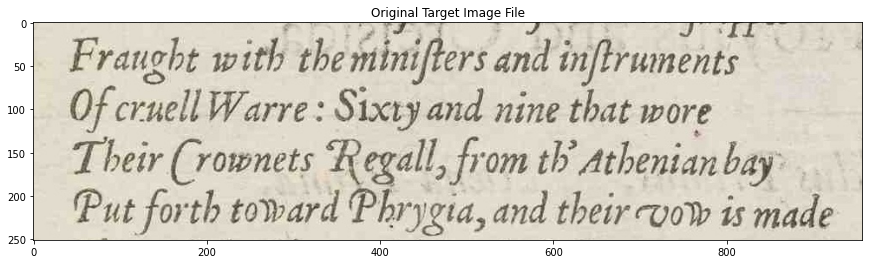

In [354]:
#@title Read and Display Target (larger) Image file:
target_image = cv2.imread(target_file_path)

fig = plt.figure(figsize=(80,4))
plt.title('Original Target Image File')
plt.imshow(cv2.cvtColor(target_image, cv2.COLOR_BGR2RGB))
plt.show()

In [355]:
#@title Read Template (smaller) Image file:

print('use_previous_template: ' + str(use_previous_template))

template_file_path = None
# enable 'previous' control:

if use_previous_template == True:
  # use previous template image file:
  if(template_file_path == None):
    template_file_path = default_template_path
  else:
    template_file_path = previous_template_path

  print("Using Previous Template Image File: " + template_file_path)

else: #don't use previous, upload a file:

  cwd = os.getcwd() #save wd to restore.
  os.chdir(templates_dir)

  print("Choose a template (smaller) image file")
  uploaded = files.upload()

  for fn in uploaded.keys():
    template_file_path = templates_dir + fn
    write_prefs('previous_template_path', template_file_path)
    os.chdir(cwd) #restore wd. 
  
  print("Using Uploaded Template Image File: " + template_file_path)
  uploaded_file_exists = os.path.exists(template_file_path)
  if not uploaded_file_exists: print('no uploaded template image file')


use_previous_template: True
Using Previous Template Image File: /content/drive/MyDrive/Template Match/Templates/default template image.jpeg


In [356]:
#@title Preprocess the Target image data:
target_gray = cv2.cvtColor(target_image,cv2.COLOR_BGR2GRAY)
target_blur = cv2.GaussianBlur(target_gray, (5,5), 0)
target_thresh = cv2.threshold(target_blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15,15))
target_dilate = cv2.dilate(target_thresh, kernel, iterations=2)

# Find contours, obtain bounding box coordinates, and extract ROI:
cnts = cv2.findContours(target_dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
image_number = 0

/content/drive/MyDrive/Template Match/Templates/default template image.jpeg


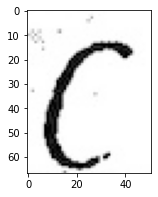

In [357]:
# Get the shape of the template:
#gd_template_file_name = '/content/drive/MyDrive/Template Match/C-1.jpeg'
print(template_file_path)
template_image = cv2.imread(template_file_path, 0)  
#template_image = cv2.imread(template_file_name, 0)  ### this is it.
# template_image = cv2.cvtColor(template_image, cv2.COLOR_BGR2RGB) no

fig = plt.figure(figsize=(80,3))
plt.imshow(cv2.cvtColor(template_image, cv2.COLOR_BGR2RGB))
plt.show()

w, h = template_image.shape[::-1]

In [358]:
#@title Apply the template matching onto the Target from the Template:
# Remember, that the size of the template should 
# be as much as possible the same, as its size in the target image.

# So, we take our image, our template, and the template matching method

res = cv2.matchTemplate(target_gray,
                        template_image,
                        cv2.TM_CCOEFF_NORMED)

min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res) 


#confidence = res[pt[1]][pt[0]]
#print(confidence)

In [359]:
# Suppose we are searching for an object which has multiple occurrences:
# In that case, we will use thresholding. 
# Let's make the threshold 0.7
threshold = 0.70

In [360]:
# Then we get the locations, that have values bigger, than our threshold:
#@title Then we get the locations, that have values bigger, than our threshold:

print("Show positions of objects in the Target which match the Template at or above the Threshold:")

loc = np.where(res >= threshold) #returns a tuple
# print(loc)
dr = pd.DataFrame(loc)
dr_transposed = dr.T # or df2.transpose()
dr_transposed.columns =['x', 'y']

styles = [dict(selector="caption",
                       props=[("text-align", "center"),
                              ("font-size", "150%"),
                              ("color", 'black')])]
dr_transposed.style.set_caption("funcioasadsaaaa").set_table_styles(styles)
dr_transposed

Show positions of objects in the Target which match the Template at or above the Threshold:


,x,y
0,121,152
1,122,151
2,122,152


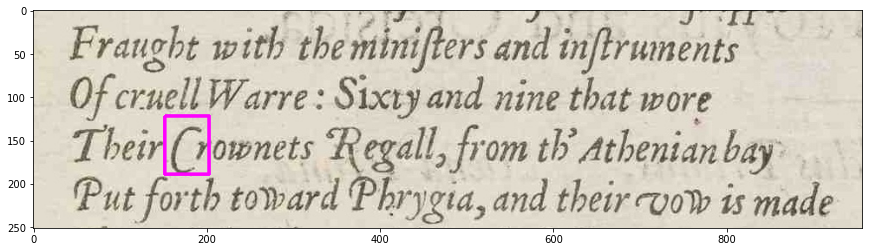

In [361]:


for pt in zip(*loc[::-1]):
    cv2.rectangle(target_image, pt, (pt[0] + w, pt[1] + h), (255,0,255), 2)

fig = plt.figure(figsize=(80,4))
plt.imshow(cv2.cvtColor(target_image, cv2.COLOR_BGR2RGB))
# plt.imshow(target_image)
# plt.show()


In [362]:
#!jupyter nbconvert --to html 'Template Match 1623 v17.ipynb'

